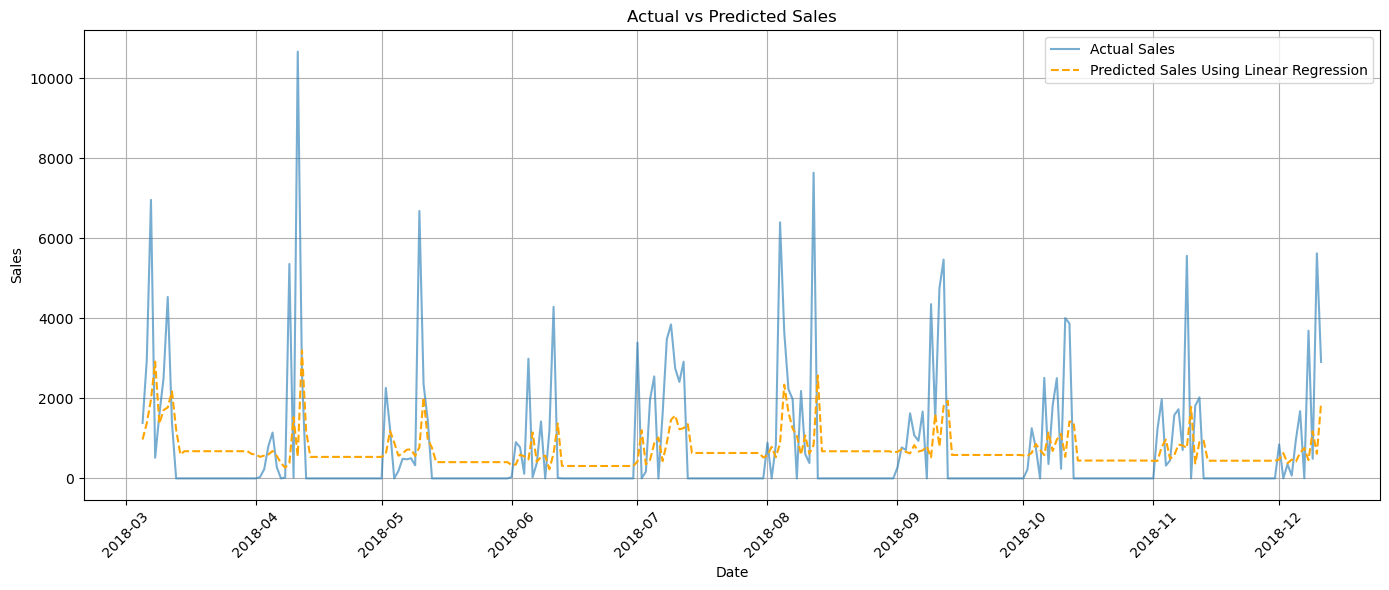

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Load the dataset
df = pd.read_csv("cleaned_sales_data.csv")

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df.set_index('Order Date', inplace=True)

# Daily aggregated sales
df_daily = df['Sales'].resample('D').sum()

# Estimate trend using 30-day moving average
window_size = 30
df_trend = df_daily.to_frame(name='Sales')
df_trend['Moving_Avg'] = df_trend['Sales'].rolling(window=window_size).mean()

# Detrending: Remove the estimated trend
df_trend['Detrended'] = df_trend['Sales'] - df_trend['Moving_Avg']
# Drop NaNs caused by moving average
df_trend.dropna(inplace=True)

# Create lag feature on detrended sales
df_trend['Lagged_Detrended'] = df_trend['Detrended'].shift(1)

# Drop resulting NaNs
df_trend.dropna(inplace=True)

# Train/test split
split_idx = int(len(df_trend) * 0.8)
train = df_trend.iloc[:split_idx]
test = df_trend.iloc[split_idx:]

# Features and targets
x_train = train[['Lagged_Detrended']]
y_train = train['Detrended']
x_test = test[['Lagged_Detrended']]
y_test = test['Detrended']

# Train linear regression on detrended data
model = LinearRegression()
model.fit(x_train, y_train)

# Predict detrended sales
detrended_preds = model.predict(x_test)

# Add back the trend to get final predicted sales
test = test.copy()
test['Predicted_Detrended'] = detrended_preds
test['Final_Predicted_Sales'] = test['Predicted_Detrended'] + test['Moving_Avg']

# Plot: Actual Sales vs Predicted Sales (after trend added back)
plt.figure(figsize=(14, 6))
plt.plot(test.index, test['Sales'], label='Actual Sales', alpha=0.6)
plt.plot(test.index, test['Final_Predicted_Sales'], label='Predicted Sales Using Linear Regression', color='orange', linestyle='--')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
